In [1]:
import numpy as np
import cv2
import os
import scipy

In [2]:
import torch as th
from torch import nn, optim, distributions as dist
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import random
from tqdm import tqdm
import os
import torch.nn.functional as F
from torch.utils.data import Dataset 

In [17]:
from sklearn.model_selection import train_test_split

In [19]:
batch_size = 8
learning_rate = 1e-6
epochs = 100
density_map_scale = 10
#crop_size = 512

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


In [6]:
images = []
labels = []
data_path = 'TRANCOS_v3/TRANCOS_v3/images'
for data in sorted(os.listdir(data_path)):
    basename = os.path.basename(data) # example.jpg
    #filename = os.path.splitext(basename)[0] # example
    file = os.path.splitext(basename)[1] #.jpg
    if file == '.jpg':
        images.append(data_path + '/' + basename)
    elif file == '.txt':
        labels.append(data_path + '/' + basename)

In [14]:
#generate density map and save
sigma = 16
for j in tqdm(range(len(images))):
    image = cv2.imread(images[j])
    '''if image.shape[0] < crop_size or image.shape[1] < crop_size:
        continue'''
    points = []    
    with open (labels[j], 'r') as f:
        while True:
            point = f.readline()
            if not point:
                break
            point = point.split('\t')
            points.append([float(point[0]), float(point[1])])
    label_position = np.array(points)
    #label_position = np.load(labels[j])
    label_image = np.zeros((image.shape[0],image.shape[1]))
    for i in range(len(label_position)):
        label_image[int(label_position[i,1]) - 1, int(label_position[i,0]) - 1] = 1
    density_map = scipy.ndimage.gaussian_filter(label_image, sigma = sigma, truncate= sigma)
    if not os.path.isdir('density_map_npy_16'):
            os.mkdir('density_map_npy_16')
    basename_label = os.path.basename(labels[j]) # example.jpg
    filename_label = os.path.splitext(basename_label)[0] # example
    #np.save(('density_map_npy/'+filename_image+'.npy'),image)
    np.save(('density_map_npy_16/'+filename_label),density_map)

100%|██████████| 1244/1244 [03:38<00:00,  5.69it/s]


In [15]:
labels = []
data_path = 'density_map_npy_16'
for data in sorted(os.listdir(data_path)):
    basename = os.path.basename(data) # example.jpg
    labels.append(data_path + '/' + basename)

In [18]:
train_image, val_image, train_label, val_label = train_test_split(images, labels, test_size=0.2, random_state=42)
len(train_image), len(val_image)

(995, 249)

In [20]:
class TrainDataset(Dataset):
    def __init__(self, images = train_image, labels = train_label, crop_size = 512):
      self.images = images
      self.labels = labels
      #self.sigma = 6
      self.density_map_scale = density_map_scale
      #self.crop_size = crop_size
    def __getitem__(self, index):
      # 讀取每次迭代的資料集中第 idx  資料
      #print(index)
      image = cv2.imread(self.images[index])
      #print(image.shape)
      density_map = np.load(self.labels[index])
      density_map = np.expand_dims(density_map, axis=2)
      '''label_position = np.load(self.labels[index])
      label_image = np.zeros((image.shape[0],image.shape[1]))
      for i in range(len(label_position)):
          label_image[int(label_position[i,1]) - 1, int(label_position[i,0]) - 1] = 1'''
      #label_image = np.expand_dims(label_image, axis=2)
      #random crop the image
      '''if image.shape[0] <= self.crop_size:
          start_x = 0
      else:
          start_x = random.randint(0, image.shape[0] - self.crop_size)
      if image.shape[1] <= self.crop_size:
          start_y = 0
      else:
          start_y = random.randint(0, image.shape[1] - self.crop_size)
      image = image[start_x:start_x+self.crop_size, start_y:start_y+self.crop_size, :] '''
      image = self.transform(image)
      
      #density_map = density_map[start_x:start_x+self.crop_size, start_y:start_y+self.crop_size, :]  
      #density_map = gaussian_filter_density(label_image) 
      count = np.sum(density_map)
      density_map *= self.density_map_scale
      density_map = density_map.transpose((2, 0, 1))
      density_map = torch.from_numpy(density_map)

      return image, density_map, count
    def __len__(self):
      return len(self.images)
    
    def transform(self, image):
      #image = torch.from_numpy(image)
      
      transform = transforms.Compose(
          [          
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ])
      image = transform(image)
      return image

In [22]:
train_dataset = TrainDataset()
train_loader =  torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0)

In [25]:
validation_dataset = TrainDataset(images=val_image, labels=val_label)
validation_loader =  torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0)

In [27]:
#CSRNet
import torch.nn as nn
import torch
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                #self.frontend.state_dict().items()[i][1].data[:] = mod.state_dict().items()[i][1].data[:]
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = F.upsample_bilinear(x, scale_factor=8)
        x = self.output_layer(x)
        #x = F.upsample_bilinear(x, scale_factor=8)
        #x = nn.Conv2d(1, 1, 1)(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [39]:
model = CSRNet().to(device)

c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
from torchsummary import summary
summary(model, input_size=(3,640,480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 640, 480]           1,792
              ReLU-2         [-1, 64, 640, 480]               0
            Conv2d-3         [-1, 64, 640, 480]          36,928
              ReLU-4         [-1, 64, 640, 480]               0
         MaxPool2d-5         [-1, 64, 320, 240]               0
            Conv2d-6        [-1, 128, 320, 240]          73,856
              ReLU-7        [-1, 128, 320, 240]               0
            Conv2d-8        [-1, 128, 320, 240]         147,584
              ReLU-9        [-1, 128, 320, 240]               0
        MaxPool2d-10        [-1, 128, 160, 120]               0
           Conv2d-11        [-1, 256, 160, 120]         295,168
             ReLU-12        [-1, 256, 160, 120]               0
           Conv2d-13        [-1, 256, 160, 120]         590,080
             ReLU-14        [-1, 256, 1

c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torch\nn\functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [41]:
def validation(val_dataloader, criterion):
    print('\n---validation---')
    val_loss = 0.0
    val_mse = 0.0
    val_mae = 0.0
    model.eval()                   
    with torch.no_grad():
        for val_batch_idx, val_data in enumerate(val_dataloader):
            image = val_data[0]
            image = image.float()
            target_image = val_data[1]
            target_image = target_image.float()
            image, target_image = image.to(device), target_image.to(device)
            outputs = model(image)
            loss = criterion(target_image, outputs)
            val_loss += (loss.item() * len(val_data))
            count = val_data[2]
            mae = 0
            mse = 0
            for i in range(len(outputs)):
                predict_count = torch.sum(outputs[i]).cpu().detach().numpy().item() / density_map_scale
                target_count = count[i].item()
                mse += np.square(predict_count - target_count)
                mae += np.abs(predict_count - target_count)
            print('batch:', val_batch_idx, 'val_mse:', mse / len(outputs),'val_mae:', mae / len(outputs), end='\r')
            val_mse += mse
            val_mae += mae
    validation_size = val_batch_idx*batch_size + len(val_data)
    val_loss /= validation_size
    val_mse /= validation_size
    val_mae /= validation_size
    return val_loss, val_mse, val_mae

In [42]:
def train(model, train_dataloader, val_dataloader, epoch_size,learning_rate = 1e-3, optimizers = 'Adam', model_save_name = 'vgg19', validation_Flag = True):
    criterion = torch.nn.MSELoss().cuda()
    history = dict()
    train_history_loss = []
    train_history_mse = []
    train_history_mae = []
    
    val_history_loss = []
    val_history_mse = []
    val_history_mae = []
    
    if optimizers == 'Adam':
        lr = learning_rate
        optimizer = optim.Adam(model.parameters(), lr)
        
    best_loss = np.inf    
    early_stoping_count = 0
    early_stoping_max = 20
    
    if optimizers == 'SGD':
        optimizer = optim.SGD(model.parameters(
        ), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(
        optimizer, step_size=5, gamma=0.1)
   
    for epoch in tqdm(range(epoch_size)):
        #optimizer = optim.Adam(model.parameters(), lr)
        train_loss = 0.0
        train_mse = 0.0
        train_mae = 0.0
        for batch_idx, data in enumerate(train_dataloader):
            model.train()
            image = data[0]
            image = image.float()
            #image = image.cuda()
            target_image = data[1]
            target_image = target_image.float()
            #target_image = target_image.cuda()
            image, target_image = image.to(device), target_image.to(device)
            # clear gradient
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(image)  
            loss = criterion(target_image, outputs) 
            loss.backward()
            optimizer.step()
            train_loss += (loss.item() * len(data))
            
            count = data[2]
            #factor = data[3]
           
            mae = 0
            mse = 0
            for i in range(len(outputs)):   
                target_count = count[i].item() 
                predict_count = torch.sum(outputs[i]).cpu().detach().numpy().item() / density_map_scale
                mse += np.square(predict_count - target_count)
                mae += np.abs(predict_count - target_count)
            print('batch:', batch_idx, 'train_mse:', mse / len(outputs),'train_mae:', mae / len(outputs), end='\r')
            train_mse += mse 
            train_mae += mae
            
        #print training result
        train_history_mse.append(train_mse/(batch_idx*batch_size + len(data)))
        train_history_mae.append(train_mae/(batch_idx*batch_size + len(data)))
        print('train mse:', train_mse/(batch_idx*batch_size + len(data)), 'train mae', train_mae/(batch_idx*batch_size + len(data)))
        train_history_loss.append(train_loss/(batch_idx*batch_size + len(data)))
        print("train loss:",train_loss/(batch_idx*batch_size + len(data)))
        
        if validation_Flag:
            val_loss, val_mse, val_mae = validation(val_dataloader, criterion)                        
            val_history_mse.append(val_mse)
            val_history_mae.append(val_mae)
            print('val mse:', val_mse, 'val mae', val_mae)
            val_history_loss.append(val_loss)
            print("val loss:",val_loss)
            
            if not os.path.isdir('save_weights'):
                os.mkdir('save_weights')
            #save weight
            if val_loss < best_loss:
                best_loss = val_loss
                early_stoping_count = 0
                torch.save(model, "./save_weights/"+ model_save_name+".pt")
                print('\nmodel improve!')
            #check earlystoping
            early_stoping_count += 1
            if early_stoping_count > early_stoping_max:
                print('validation loss not improve in ', early_stoping_count,'epochs, early stoping!')
                break
     
    torch.save(model, "./save_weights/" +model_save_name +"_ final" +"_.pt")      
    history['train_mse'] = train_history_mse
    history['train_mae'] = train_history_mae
    history['train_loss'] = train_history_loss
    if validation_Flag:
        history['val_mse'] = val_history_mse
        history['val_mae'] = val_history_mae
        history['val_loss'] = val_history_loss
    return history

In [43]:
history = train(model=model, train_dataloader=train_loader, val_dataloader = validation_loader, epoch_size=epochs, learning_rate=learning_rate,optimizers="Adam", model_save_name='CSRNet_sigma16')

  0%|          | 0/100 [00:00<?, ?it/s]

train mse: 276.1164027859416 train mae 13.3417926224751702844238281248
train loss: 3.6148214627730944e-06

---validation---


  1%|          | 1/100 [05:44<9:29:13, 344.98s/it]

val mse: 269.66674096671545 val mae 13.22323275258341551708984372
val loss: 3.2036609066623834e-06

model improve!
train mse: 296.6554014858516 train mae 13.5702247861162549124348937665
train loss: 2.7232710155987488e-06

---validation---


  2%|▏         | 2/100 [11:23<9:17:43, 341.47s/it]

val mse: 238.7211374227598 val mae 12.07456711848893661523437499
val loss: 2.527784016207709e-06

model improve!
train mse: 239.5328972191721 train mae 11.9284410413425825887044270636
train loss: 2.3488298090191322e-06

---validation---


  3%|▎         | 3/100 [16:11<8:32:13, 316.84s/it]

val mse: 170.78264371953424 val mae 10.1065140560803628691406264
val loss: 2.2675970899671304e-06

model improve!
train mse: 196.30494846381993 train mae 10.838105899676696706136067486
train loss: 2.164316802877487e-06

---validation---


  4%|▍         | 4/100 [20:49<8:02:30, 301.57s/it]

val mse: 144.8994202649719 val mae 9.20935248568713470336914063
val loss: 2.116915566039532e-06

model improve!
train mse: 178.0001124722171 train mae 10.3096818021074594049479166555
train loss: 2.054116793941597e-06

---validation---


  5%|▌         | 5/100 [25:34<7:48:07, 295.66s/it]

val mse: 133.7024816814653 val mae 8.8065819303352985517578125014
val loss: 2.023837801261037e-06

model improve!
train mse: 167.38655264417665 train mae 9.9478023379531946153157552057
train loss: 1.97921561645749e-06

---validation---


  6%|▌         | 6/100 [30:19<7:37:18, 291.90s/it]

val mse: 127.47478875348101 val mae 8.553688401909938890136718743
val loss: 1.960133621799602e-06

model improve!
train mse: 159.95105903879642 train mae 9.6804787042512459556681315086
train loss: 1.9233043256911024e-06

---validation---


  7%|▋         | 7/100 [35:05<7:29:18, 289.88s/it]

val mse: 123.21998085718741 val mae 8.364301418593202817871093743
val loss: 1.9133257758285363e-06

model improve!
train mse: 154.1211707260186 train mae 9.45709008758391677811686197759
train loss: 1.8788580476682534e-06

---validation---


  8%|▊         | 8/100 [39:49<7:21:44, 288.09s/it]

val mse: 119.88137672154645 val mae 8.21215828215458594238281236
val loss: 1.8769175687658025e-06

model improve!
train mse: 149.41382723822994 train mae 9.2726202599606911044108073058
train loss: 1.8419550697994302e-06

---validation---


  9%|▉         | 9/100 [44:58<7:26:56, 294.68s/it]

val mse: 117.2212326837629 val mae 8.1054167728500045429687511
val loss: 1.847320810298132e-06

model improve!
train mse: 145.48132096723486 train mae 9.1144286818001137073974609371
train loss: 1.8101782972561563e-06

---validation---


 10%|█         | 10/100 [50:28<7:38:08, 305.43s/it]

val mse: 114.95670232532454 val mae 8.00723918899597707031249993
val loss: 1.8223008529199737e-06

model improve!
train mse: 142.12260396206526 train mae 8.9784664004531939383138023444
train loss: 1.7820820441063267e-06

---validation---


 11%|█         | 11/100 [55:26<7:30:03, 303.41s/it]

val mse: 112.98855817302713 val mae 7.91446593995113448144531236
val loss: 1.8004809535558747e-06

model improve!
train mse: 139.18661807623985 train mae 8.8605144144182878305257161525
train loss: 1.7567142558664501e-06

---validation---


 12%|█▏        | 12/100 [1:00:10<7:16:16, 297.46s/it]

val mse: 111.2113032114785 val mae 7.827083067874983594482421875
val loss: 1.7810417299492347e-06

model improve!
train mse: 136.5757620942933 train mae 8.75822229893363110616048177255
train loss: 1.733429726254825e-06

---validation---


 13%|█▎        | 13/100 [1:05:16<7:14:59, 299.99s/it]

val mse: 109.57468965290457 val mae 7.74289924044058168945312507
val loss: 1.7634297645386087e-06

model improve!
train mse: 134.23214498986505 train mae 8.6674480787114252604980468859
train loss: 1.7118485693892362e-06

---validation---


 14%|█▍        | 14/100 [1:10:29<7:15:23, 303.76s/it]

val mse: 108.14433245207282 val mae 7.6674981774561894257812555
val loss: 1.7473856013135351e-06

model improve!
train mse: 132.10401863175562 train mae 8.5850308457571098464558919283
train loss: 1.691730080184339e-06

---validation---


 15%|█▌        | 15/100 [1:15:14<7:02:18, 298.10s/it]

val mse: 106.86468279934876 val mae 7.59928165754949751464843743
val loss: 1.7326356526725695e-06

model improve!
train mse: 130.11345918687334 train mae 8.5084404574446926804606119867
train loss: 1.6728723563007301e-06

---validation---


 16%|█▌        | 16/100 [1:20:29<7:04:32, 303.24s/it]

val mse: 105.65633715440735 val mae 7.53551283756575905273437514
val loss: 1.718940195197968e-06

model improve!
train mse: 128.25207910642064 train mae 8.4397734146501589962972005213
train loss: 1.6550618876872296e-06

---validation---


 17%|█▋        | 17/100 [1:26:07<7:14:10, 313.87s/it]

val mse: 104.55350174228433 val mae 7.48130935729737356249999993
val loss: 1.7061313809178222e-06

model improve!
train mse: 126.52418450290169 train mae 8.3772043582782087631632486994
train loss: 1.6381966420637248e-06

---validation---


 18%|█▊        | 18/100 [1:31:06<7:02:42, 309.30s/it]

val mse: 103.5563466393988 val mae 7.435641139057052905761718757
val loss: 1.6941182322799464e-06

model improve!
train mse: 124.83911349022965 train mae 8.3162030458689963084920247403
train loss: 1.6221601940536739e-06

---validation---


 19%|█▉        | 19/100 [1:35:49<6:46:55, 301.42s/it]

val mse: 102.5962050455702 val mae 7.3924249352686884394531250075
val loss: 1.682837431603893e-06

model improve!
train mse: 123.21692762148882 train mae 8.2567616563346528237304687839
train loss: 1.606852427485777e-06

---validation---


 20%|██        | 20/100 [1:40:34<6:35:13, 296.42s/it]

val mse: 101.71636126240908 val mae 7.35091225065558564331054686
val loss: 1.6722415945780476e-06

model improve!
train mse: 121.67952843747092 train mae 8.1995997335922782639160156359
train loss: 1.5922259630562036e-06

---validation---


 21%|██        | 21/100 [1:45:36<6:32:33, 298.14s/it]

val mse: 100.83229838579634 val mae 7.306731885932835083007812514
val loss: 1.6622120402966703e-06

model improve!
train mse: 120.20604961625226 train mae 8.1450400025640930166829427078
train loss: 1.5782171132842042e-06

---validation---


 22%|██▏       | 22/100 [1:50:48<6:33:08, 302.41s/it]

val mse: 100.01739499320227 val mae 7.26360367854752685961914062
val loss: 1.6527504971620429e-06

model improve!
train mse: 118.78320558051044 train mae 8.0931147160362331984252929693
train loss: 1.5647599801370198e-06

---validation---


 23%|██▎       | 23/100 [1:55:32<6:20:47, 296.72s/it]

val mse: 99.23434822811043 val mae 7.22089600582046875195312486
val loss: 1.6437658001066383e-06

model improve!
train mse: 117.42239115050323 train mae 8.0444043076098249153238932394
train loss: 1.5517906433900925e-06

---validation---


 24%|██▍       | 24/100 [2:00:16<6:10:56, 292.85s/it]

val mse: 98.55793583095529 val mae 7.181667422108439557617187536
val loss: 1.6353017461920516e-06

model improve!
train mse: 116.08702274771592 train mae 7.9958934918120851159261067715
train loss: 1.539279487336551e-06

---validation---


 25%|██▌       | 25/100 [2:05:03<6:04:01, 291.22s/it]

val mse: 97.86145040811465 val mae 7.1411615561679047172851562486
val loss: 1.6272466333443972e-06

model improve!
train mse: 114.81244666713572 train mae 7.9502466886127428506673177266
train loss: 1.5272209220117232e-06

---validation---


 26%|██▌       | 26/100 [2:10:02<6:02:03, 293.56s/it]

val mse: 97.23508230651933 val mae 7.1040702485468294859375000014
val loss: 1.6196132261949925e-06

model improve!
train mse: 113.56253488806716 train mae 7.9037598683726261053059895974
train loss: 1.5155338092909142e-06

---validation---


 27%|██▋       | 27/100 [2:15:37<6:12:07, 305.85s/it]

val mse: 96.63183367783846 val mae 7.06867955424396350341796875
val loss: 1.612343832523647e-06

model improve!
train mse: 112.34975580284863 train mae 7.8586995953890569581298828139
train loss: 1.504211940501687e-06

---validation---


 28%|██▊       | 28/100 [2:20:44<6:07:40, 306.40s/it]

val mse: 96.04562767891495 val mae 7.0339430546855526562499999993
val loss: 1.6054526953435034e-06

model improve!
train mse: 111.20127374584838 train mae 7.8158867679768528986002604174
train loss: 1.493260354084728e-06

---validation---


 29%|██▉       | 29/100 [2:25:26<5:53:58, 299.14s/it]

val mse: 95.55042132114266 val mae 7.0015575515321515956542968757
val loss: 1.5989395320227423e-06

model improve!
train mse: 110.08979400786255 train mae 7.7739555489238162926228841173
train loss: 1.4826192955525819e-06

---validation---


 30%|███       | 30/100 [2:30:11<5:43:43, 294.62s/it]

val mse: 95.0709206056889 val mae 6.9685457753945153892211914062
val loss: 1.5927257247160623e-06

model improve!
train mse: 108.98748318843036 train mae 7.7331209238330346755371093775
train loss: 1.4722498912050098e-06

---validation---


 31%|███       | 31/100 [2:35:06<5:39:00, 294.78s/it]

val mse: 94.59805641649203 val mae 6.9367850375840448327636718743
val loss: 1.586783328202293e-06

model improve!
train mse: 107.91696165188444 train mae 7.6933002644447785900878908792
train loss: 1.4621639540756456e-06

---validation---


 32%|███▏      | 32/100 [2:40:25<5:42:16, 302.01s/it]

val mse: 94.16781388496032 val mae 6.9074700161755330463867187493
val loss: 1.5811242021474059e-06

model improve!
train mse: 106.87287030974582 train mae 7.6551837165870856690673828156
train loss: 1.4523166691558334e-06

---validation---


 33%|███▎      | 33/100 [2:45:10<5:31:32, 296.91s/it]

val mse: 93.77894581102386 val mae 6.8795025707716011768798828125
val loss: 1.5757302689853967e-06

model improve!
train mse: 105.85395381994576 train mae 7.6169687863450547363281250024
train loss: 1.4426895184021931e-06

---validation---


 34%|███▍      | 34/100 [2:49:54<5:22:36, 293.27s/it]

val mse: 93.34521509683195 val mae 6.851277798960407485839843752
val loss: 1.5705167636288857e-06

model improve!
train mse: 104.85372968029762 train mae 7.5798310483999573746744794656
train loss: 1.4332808671236823e-06

---validation---


 35%|███▌      | 35/100 [2:54:39<5:14:44, 290.53s/it]

val mse: 92.92699750682826 val mae 6.8236411653191915004882812507
val loss: 1.5655298692042534e-06

model improve!
train mse: 103.85811136580442 train mae 7.5429200529932362019042969076
train loss: 1.4240793866268739e-06

---validation---


 36%|███▌      | 36/100 [2:59:17<5:06:04, 286.94s/it]

val mse: 92.52655692792294 val mae 6.7964657483347857177734374993
val loss: 1.5607274790055957e-06

model improve!
train mse: 102.89891916981057 train mae 7.5066476340749135326253255244
train loss: 1.4150915505488046e-06

---validation---


 37%|███▋      | 37/100 [3:03:42<4:54:23, 280.37s/it]

val mse: 92.09585911017255 val mae 6.76981501484297833007812507
val loss: 1.556114954884645e-06

model improve!
train mse: 101.94511293440993 train mae 7.4695836926944276627197265955
train loss: 1.4062848515378898e-06

---validation---


 38%|███▊      | 38/100 [3:08:06<4:44:40, 275.50s/it]

val mse: 91.72786683601056 val mae 6.746327616778977380981445312
val loss: 1.5516974874834745e-06

model improve!
train mse: 101.01664204616472 train mae 7.4330923891307139720458984407
train loss: 1.3976699642740303e-06

---validation---


 39%|███▉      | 39/100 [3:11:52<4:24:47, 260.46s/it]

val mse: 91.37582579967395 val mae 6.7248190283300383261718751
val loss: 1.54748600160896e-06

model improve!
train mse: 100.10655209539416 train mae 7.3970442491080881942545573322
train loss: 1.3892129307844436e-06

---validation---


 40%|████      | 40/100 [3:15:36<4:09:36, 249.61s/it]

val mse: 91.06050626709481 val mae 6.704043682447942702636718764
val loss: 1.543442744172266e-06

model improve!
train mse: 99.2307809725768 train mae 7.362004179834729278310139974245
train loss: 1.3809283124677832e-06

---validation---


 41%|████      | 41/100 [3:19:20<3:57:54, 241.95s/it]

val mse: 90.76298331627747 val mae 6.6834389979145925827636718743
val loss: 1.5395648005327516e-06

model improve!
train mse: 98.3635782251248 train mae 7.326036906793486029098510742227
train loss: 1.3727929244074156e-06

---validation---


 42%|████▏     | 42/100 [3:23:04<3:48:33, 236.44s/it]

val mse: 90.45009776080913 val mae 6.662845511265483375610351563
val loss: 1.5357804012315154e-06

model improve!
train mse: 97.50242183880708 train mae 7.28979902641258365475463867213
train loss: 1.364773515431341e-06

---validation---


 43%|████▎     | 43/100 [3:26:47<3:40:57, 232.58s/it]

val mse: 90.11490473086272 val mae 6.6422340727422349340820312486
val loss: 1.532113232989137e-06

model improve!
train mse: 96.65768108582928 train mae 7.25374594453591134765625000036
train loss: 1.3568929242540631e-06

---validation---


 44%|████▍     | 44/100 [3:30:31<3:34:37, 229.95s/it]

val mse: 89.84086656523668 val mae 6.62376809291155722924804687
val loss: 1.5286118269501907e-06

model improve!
train mse: 95.81199204817919 train mae 7.21750965290932490480550130244
train loss: 1.3491229761922255e-06

---validation---


 45%|████▌     | 45/100 [3:34:14<3:28:59, 227.99s/it]

val mse: 89.56651745020982 val mae 6.60546875: 3.3688293457031264
val loss: 1.525236787228389e-06

model improve!
train mse: 94.973137525894 train mae 7.1810708457141663200083414713575
train loss: 1.341462066376157e-06

---validation---


 46%|████▌     | 46/100 [3:37:59<3:24:13, 226.92s/it]

val mse: 89.29444462005964 val mae 6.5873727198141024929199218757
val loss: 1.5219945722325732e-06

model improve!
train mse: 94.14187091213206 train mae 7.14526327315287744728597005543
train loss: 1.3339240021008635e-06

---validation---


 47%|████▋     | 47/100 [3:41:43<3:19:42, 226.08s/it]

val mse: 89.04525007293088 val mae 6.5696305050792913356933593764
val loss: 1.5188621216521096e-06

model improve!
train mse: 93.33651339567311 train mae 7.10992591666216924772135416695
train loss: 1.3265063318439429e-06

---validation---


 48%|████▊     | 48/100 [3:45:28<3:15:35, 225.69s/it]

val mse: 88.83705115906687 val mae 6.5527789902402096855468749993
val loss: 1.5158525887370679e-06

model improve!
train mse: 92.54425863137662 train mae 7.07423276124886881650797526072
train loss: 1.3191796356226973e-06

---validation---


 49%|████▉     | 49/100 [3:49:12<3:11:29, 225.29s/it]

val mse: 88.57056984919389 val mae 6.535427534247773559790039064
val loss: 1.5129050554598535e-06

model improve!
train mse: 91.76229596564956 train mae 7.03951298545952572277832031575
train loss: 1.311944909196715e-06

---validation---


 50%|█████     | 50/100 [3:52:56<3:07:29, 224.99s/it]

val mse: 88.32606033449855 val mae 6.518745160957731742065429686
val loss: 1.510067680651971e-06

model improve!
train mse: 90.99040036220848 train mae 7.00572270532349269529215494835
train loss: 1.3048015119206707e-06

---validation---


 51%|█████     | 51/100 [3:56:40<3:03:30, 224.70s/it]

val mse: 88.08114579899832 val mae 6.5020604167801440617675781264
val loss: 1.5072881964500762e-06

model improve!
train mse: 90.22435108149523 train mae 6.97218530626153219220987955754
train loss: 1.2977366514545125e-06

---validation---


 52%|█████▏    | 52/100 [4:00:25<2:59:43, 224.67s/it]

val mse: 87.86248143592184 val mae 6.485194810358176800781250014
val loss: 1.504610141742467e-06

model improve!
train mse: 89.44500534232893 train mae 6.93806487883754656797281901073
train loss: 1.290740925839632e-06

---validation---


 53%|█████▎    | 53/100 [4:04:09<2:55:51, 224.50s/it]

val mse: 87.65210521415722 val mae 6.4703659787121047514648437486
val loss: 1.5020565809161968e-06

model improve!
train mse: 88.67919928073356 train mae 6.90383518161485619173177083532
train loss: 1.2838342053643586e-06

---validation---


 54%|█████▍    | 54/100 [4:07:53<2:52:04, 224.45s/it]

val mse: 87.44925254798142 val mae 6.4567244024390718698730468757
val loss: 1.4995876275557147e-06

model improve!
train mse: 87.92746929189 train mae 6.86940334070866852819020589192736
train loss: 1.277000225726894e-06

---validation---


 55%|█████▌    | 55/100 [4:11:38<2:48:16, 224.38s/it]

val mse: 87.29123752754711 val mae 6.4445040820604293508300781264
val loss: 1.4972419696089518e-06

model improve!
train mse: 87.17598918921995 train mae 6.83453226367432462344360351615
train loss: 1.2702313245486337e-06

---validation---


 56%|█████▌    | 56/100 [4:15:22<2:44:31, 224.35s/it]

val mse: 87.15142559280996 val mae 6.4333777256695880312499999986
val loss: 1.4949695431972346e-06

model improve!
train mse: 86.43751549062274 train mae 6.80059804408394723434448242226
train loss: 1.2635301453056356e-06

---validation---


 57%|█████▋    | 57/100 [4:19:06<2:40:44, 224.28s/it]

val mse: 87.022692974755 val mae 6.42211894001143702182006835937
val loss: 1.4927444915854836e-06

model improve!
train mse: 85.69237370313951 train mae 6.76600543841644668192545573226
train loss: 1.2568823435754327e-06

---validation---


 58%|█████▊    | 58/100 [4:22:50<2:36:56, 224.20s/it]

val mse: 86.90886009356187 val mae 6.4110471140340977304687500014
val loss: 1.490613692250367e-06

model improve!
train mse: 84.96379546789638 train mae 6.73206765563044759010823567995
train loss: 1.2502897953622343e-06

---validation---


 59%|█████▉    | 59/100 [4:26:35<2:33:17, 224.32s/it]

val mse: 86.8151748698842 val mae 6.400773474704695021606445314
val loss: 1.488561904814531e-06

model improve!
train mse: 84.23819372816119 train mae 6.69812050670834530161539713574
train loss: 1.2437295673458063e-06

---validation---


 60%|██████    | 60/100 [4:30:19<2:29:30, 224.27s/it]

val mse: 86.72367888534292 val mae 6.39029623692729383911132813
val loss: 1.4865936119816929e-06

model improve!
train mse: 83.50537505393513 train mae 6.66387170456162567753092447946
train loss: 1.2372259989069104e-06

---validation---


 61%|██████    | 61/100 [4:34:03<2:25:42, 224.17s/it]

val mse: 86.68436759487965 val mae 6.381342817207732948730468736
val loss: 1.4847245174823332e-06

model improve!
train mse: 82.77733777654521 train mae 6.62978050807013777817789713573
train loss: 1.230768702610581e-06

---validation---


 62%|██████▏   | 62/100 [4:37:47<2:22:00, 224.22s/it]

val mse: 86.65497075039636 val mae 6.372575311546788334960937514
val loss: 1.4829657377150901e-06

model improve!
train mse: 82.0412238691393 train mae 6.595208826112987289210001627633
train loss: 1.224348413950738e-06

---validation---


 63%|██████▎   | 63/100 [4:41:31<2:18:16, 224.23s/it]

val mse: 86.66392064185493 val mae 6.367138696191795559619140625
val loss: 1.4812937028167711e-06

model improve!
train mse: 81.32865813291573 train mae 6.56128692780307617742919921915
train loss: 1.2179967624337653e-06

---validation---


 64%|██████▍   | 64/100 [4:45:16<2:14:35, 224.31s/it]

val mse: 86.71930294742135 val mae 6.365894241636964683349609375
val loss: 1.479729358794589e-06

model improve!
train mse: 80.62031933373493 train mae 6.52758852934717415030924479195
train loss: 1.2116812530479565e-06

---validation---


 65%|██████▌   | 65/100 [4:49:00<2:10:51, 224.34s/it]

val mse: 86.75012296020695 val mae 6.3645087010357140136718750705
val loss: 1.4782230901761227e-06

model improve!
train mse: 79.89536435649 train mae 6.493182817775403.2060251871744836
train loss: 1.2053894461681026e-06

---validation---


 66%|██████▌   | 66/100 [4:52:45<2:07:08, 224.38s/it]

val mse: 86.85365429330656 val mae 6.36748866958922955566406243
val loss: 1.4767695364684463e-06

model improve!
train mse: 79.19998948823147 train mae 6.46045009977253871608479817744
train loss: 1.1991671539335447e-06

---validation---


 67%|██████▋   | 67/100 [4:56:28<2:03:18, 224.19s/it]

val mse: 86.91463949968242 val mae 6.369185118656232534912109375
val loss: 1.4753233447761495e-06

model improve!
train mse: 78.4917888146945 train mae 6.426565853099726885630289713585
train loss: 1.1929508969275852e-06

---validation---


 68%|██████▊   | 68/100 [5:00:12<1:59:32, 224.15s/it]

val mse: 87.02850385224625 val mae 6.37219214572374518823242188
val loss: 1.4739860465040301e-06

model improve!
train mse: 77.78427876623216 train mae 6.39326404130638650138346354475
train loss: 1.1867772652875093e-06

---validation---


 69%|██████▉   | 69/100 [5:03:56<1:55:44, 224.01s/it]

val mse: 87.19279232624518 val mae 6.378799219625402682128906255
val loss: 1.4727320661900212e-06

model improve!
train mse: 77.09420068310534 train mae 6.36086717615175606542968750036
train loss: 1.1806376317248184e-06

---validation---


 70%|███████   | 70/100 [5:07:40<1:52:02, 224.10s/it]

val mse: 87.37616109911603 val mae 6.386624850694876121093752963
val loss: 1.4715147274608649e-06

model improve!
train mse: 76.41015440045317 train mae 6.32887408462601157363891601595
train loss: 1.1745311197654102e-06

---validation---


 71%|███████   | 71/100 [5:11:25<1:48:20, 224.14s/it]

val mse: 87.6024758977326 val mae 6.3957033985639455208007812506
val loss: 1.4703602104476654e-06

model improve!
train mse: 75.72501677550514 train mae 6.29590004695719508713785807314
train loss: 1.1684504965269846e-06

---validation---


 72%|███████▏  | 72/100 [5:15:09<1:44:37, 224.18s/it]

val mse: 87.86797335036046 val mae 6.406517302372539527734374986
val loss: 1.46928667288603e-06

model improve!
train mse: 75.04553018296336 train mae 6.26281855137503947643025716186
train loss: 1.1624045229800503e-06

---validation---


 73%|███████▎  | 73/100 [5:18:54<1:40:55, 224.29s/it]

val mse: 88.15820837098049 val mae 6.419686439787720541406254605
val loss: 1.4683081036922254e-06

model improve!
train mse: 74.37147215582146 train mae 6.22947835030867325492350260445
train loss: 1.1563881116671837e-06

---validation---


 74%|███████▍  | 74/100 [5:22:38<1:37:12, 224.31s/it]

val mse: 88.5092332675451 val mae 6.4360599107476311141357421885
val loss: 1.4674178080250236e-06

model improve!
train mse: 73.69935147942526 train mae 6.19615564930978350057983398475
train loss: 1.1504048058472034e-06

---validation---


 75%|███████▌  | 75/100 [5:26:23<1:33:30, 224.43s/it]

val mse: 88.83992193515469 val mae 6.451588962752504550683593755
val loss: 1.4665818320194723e-06

model improve!
train mse: 73.0206231783202 train mae 6.162065483361626405975341796917
train loss: 1.144436668136538e-06

---validation---


 76%|███████▌  | 76/100 [5:30:07<1:29:48, 224.52s/it]

val mse: 89.23004832290495 val mae 6.469574169143738872070312493
val loss: 1.4658311048365303e-06

model improve!
train mse: 72.35981851051227 train mae 6.12835106087689380691528320344
train loss: 1.1385058201656777e-06

---validation---


 77%|███████▋  | 77/100 [5:33:52<1:26:03, 224.48s/it]

val mse: 89.69314618708655 val mae 6.491680737985555935546875007
val loss: 1.465181347871167e-06

model improve!
train mse: 71.7041283789146 train mae 6.094854175816829331441243489617
train loss: 1.1326029967429934e-06

---validation---


 78%|███████▊  | 78/100 [5:37:36<1:22:15, 224.32s/it]

val mse: 90.13401651266354 val mae 6.51349532898678441992187571
val loss: 1.4646019811757778e-06

model improve!
train mse: 71.05334946962893 train mae 6.06082754317240554006347659434
train loss: 1.126723890222788e-06

---validation---


 79%|███████▉  | 79/100 [5:41:20<1:18:32, 224.40s/it]

val mse: 90.61881171655322 val mae 6.537876551654707566040039064
val loss: 1.4641048521870726e-06

model improve!
train mse: 70.4070800286488 train mae 6.026604784481492937723795573276
train loss: 1.120869603995807e-06

---validation---


 80%|████████  | 80/100 [5:45:05<1:14:49, 224.48s/it]

val mse: 91.13459708983626 val mae 6.5639496883073142254638671875
val loss: 1.4636865367118521e-06

model improve!
train mse: 69.77762351930978 train mae 5.99302186208753690262858072952
train loss: 1.1150599110024544e-06

---validation---


 81%|████████  | 81/100 [5:48:49<1:11:04, 224.44s/it]

val mse: 91.70621766055271 val mae 6.59209447002030557812588179
val loss: 1.4633850663943509e-06

model improve!
train mse: 69.13703076574586 train mae 5.95839936299539653626505533876
train loss: 1.10924928532e-06

---validation---


 82%|████████▏ | 82/100 [5:52:34<1:07:22, 224.60s/it]

val mse: 92.22787347799287 val mae 6.617144872657802281738281264
val loss: 1.4630984736527806e-06

model improve!
train mse: 68.4950028936355 train mae 5.923562816063964219665527343783
train loss: 1.1034518550802738e-06

---validation---


 83%|████████▎ | 83/100 [5:56:18<1:03:34, 224.38s/it]

val mse: 92.77475159745417 val mae 6.644258585774089505395507811
val loss: 1.462919844907519e-06

model improve!
train mse: 67.84493386090288 train mae 5.88794072060129761692301432322
train loss: 1.0976551487800492e-06

---validation---


 84%|████████▍ | 84/100 [6:00:02<59:49, 224.36s/it]  

val mse: 93.29258228640207 val mae 6.669064014936343015625000007
val loss: 1.4627712050288932e-06

model improve!
train mse: 67.21046260443396 train mae 5.85286606371702101765950520868
train loss: 1.0918961754269096e-06

---validation---


 85%|████████▌ | 85/100 [6:03:47<56:06, 224.43s/it]

val mse: 93.82945971140447 val mae 6.695569789932065660888671875
val loss: 1.462700909875397e-06

model improve!
train mse: 66.58471228257936 train mae 5.81842766843249690171305338767
train loss: 1.0861609676502113e-06

---validation---


 86%|████████▌ | 86/100 [6:07:32<52:23, 224.50s/it]

val mse: 94.35471622625045 val mae 6.7228703411451831264648437493
val loss: 1.4626902174244882e-06

model improve!
train mse: 65.96765291165492 train mae 5.78420929798528576873779297124
train loss: 1.0804518422620236e-06

---validation---


 87%|████████▋ | 87/100 [6:11:17<48:40, 224.68s/it]

val mse: 94.90294346698519 val mae 6.7505653594119580947265624993
val loss: 1.4627246196956925e-06
train mse: 65.35415280339149 train mae 5.75040163433132380822753906442
train loss: 1.0747663611081448e-06

---validation---


 88%|████████▊ | 88/100 [6:15:01<44:55, 224.66s/it]

val mse: 95.47744520427709 val mae 6.7791876226782327478027343736
val loss: 1.4627883124068244e-06
train mse: 64.76350402048526 train mae 5.71806652740018257434488932664
train loss: 1.0691071608091454e-06

---validation---


 89%|████████▉ | 89/100 [6:18:46<41:11, 224.65s/it]

val mse: 96.0402819430683 val mae 6.80760137550384247650146484375
val loss: 1.4629224402285554e-06
train mse: 64.17671979598778 train mae 5.68668114130221244447835286866
train loss: 1.0634613499631763e-06

---validation---


 90%|█████████ | 90/100 [6:22:31<37:27, 224.76s/it]

val mse: 96.44599163532506 val mae 6.828516232919879699951171875
val loss: 1.4629944624255267e-06
train mse: 63.58811045464997 train mae 5.65477182896293781697591146244
train loss: 1.0578297340900427e-06

---validation---


 91%|█████████ | 91/100 [6:26:16<33:42, 224.71s/it]

val mse: 96.81390174148007 val mae 6.8493830829027596500244140639
val loss: 1.463071448343831e-06
train mse: 63.01563463562499 train mae 5.62335328221922817687988281443
train loss: 1.0522238821680154e-06

---validation---


 92%|█████████▏| 92/100 [6:30:00<29:57, 224.68s/it]

val mse: 97.09890153265118 val mae 6.865999578954685366699218764
val loss: 1.463086800143344e-06
train mse: 62.43645414411762 train mae 5.59105392839441712941487630642
train loss: 1.0466289918280491e-06

---validation---


 93%|█████████▎| 93/100 [6:33:45<26:12, 224.69s/it]

val mse: 97.38792437404555 val mae 6.88278311315285225830078125
val loss: 1.4631704048096945e-06
train mse: 61.86528198356899 train mae 5.55914452097523632307942736103
train loss: 1.0410595699676693e-06

---validation---


 94%|█████████▍| 94/100 [6:37:29<22:27, 224.58s/it]

val mse: 97.54386648678832 val mae 6.892171213826335867919921875
val loss: 1.4631800754378706e-06
train mse: 61.30743148138131 train mae 5.52802524355787861789957682666
train loss: 1.0355338823483088e-06

---validation---


 95%|█████████▌| 95/100 [6:41:14<18:43, 224.63s/it]

val mse: 97.67280000198565 val mae 6.89979329508138984448242187493
val loss: 1.463219613998875e-06
train mse: 60.751997616406 train mae 5.4972376201380462107086181640873
train loss: 1.0300185886766275e-06

---validation---


 96%|█████████▌| 96/100 [6:44:59<14:58, 224.72s/it]

val mse: 97.75603208604315 val mae 6.90440892071362924401855468764
val loss: 1.463226475973343e-06
train mse: 60.203644880122255 train mae 5.4667852553171156738281283955
train loss: 1.0245217403801566e-06

---validation---


 97%|█████████▋| 97/100 [6:48:44<11:14, 224.85s/it]

val mse: 97.73468933813928 val mae 6.90348562415377226159667968736
val loss: 1.4632121813255402e-06
train mse: 59.653796089402114 train mae 5.4363956685281850935872398545
train loss: 1.0190463562729057e-06

---validation---


 98%|█████████▊| 98/100 [6:52:29<07:29, 224.76s/it]

val mse: 97.57865765247269 val mae 6.89561505260695237963867187486
val loss: 1.4630819804555344e-06
train mse: 59.12126930677112 train mae 5.40741685110120682474772135735
train loss: 1.0135913370774217e-06

---validation---


 99%|█████████▉| 99/100 [6:56:13<03:44, 224.65s/it]

val mse: 97.46090019948502 val mae 6.88904304656374228741455078139
val loss: 1.4629603550154034e-06
train mse: 58.581138017490105 train mae 5.3772889847491832728678385755
train loss: 1.0081530754360761e-06

---validation---


100%|██████████| 100/100 [6:59:58<00:00, 251.99s/it]

val mse: 97.21405784259406 val mae 6.87586136776137157672119140618
val loss: 1.4627326814965873e-06


In [45]:
import matplotlib.pyplot as plt

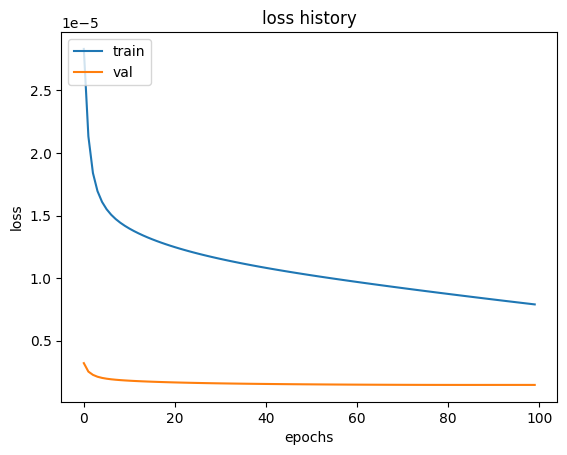

In [46]:
plt.clf()
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('loss history')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')

In [49]:
validation_dataset[0][0]

tensor([[[-1.9638, -0.6794,  1.1358,  ..., -2.0837, -2.1179, -2.1008],
         [-1.9638, -0.7137,  1.1015,  ..., -2.0837, -2.1179, -2.0837],
         [-1.9638, -0.7650,  1.0502,  ..., -2.0837, -2.1179, -2.0837],
         ...,
         [-1.8439, -1.9124, -1.9980,  ..., -2.1008, -2.1008, -2.1008],
         [-1.9980, -2.0494, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008]],

        [[-1.8782, -0.5651,  1.2906,  ..., -1.8957, -1.9657, -1.9132],
         [-1.8782, -0.6001,  1.2556,  ..., -1.8957, -1.9657, -1.8957],
         [-1.8782, -0.6527,  1.2031,  ..., -1.8957, -1.9482, -1.8957],
         ...,
         [-1.7381, -1.8081, -1.8957,  ..., -2.0007, -2.0007, -2.0007],
         [-1.8957, -1.9482, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0007, -2.0007, -2.0007]],

        [[-1.6476, -0.3404,  1.5071,  ..., -1.7522, -1.8044, -1.7696],
         [-1.6476, -0.3753,  1.4722,  ..., -1

In [54]:
validation_dataset[0][0].shape

torch.Size([3, 480, 640])

In [64]:
model = torch.load('save_weights/CSRNet_sigma16.pt')
model.eval()                   
with torch.no_grad():
    #img = torch.from_numpy(img)
    img = validation_dataset[0][0]
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    img = img.float()
    
    img = img.to(device)
    output = model(img)

c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torch\nn\functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [65]:
output = output[0].cpu().numpy().transpose((1, 2, 0))
output.shape

(480, 640, 1)

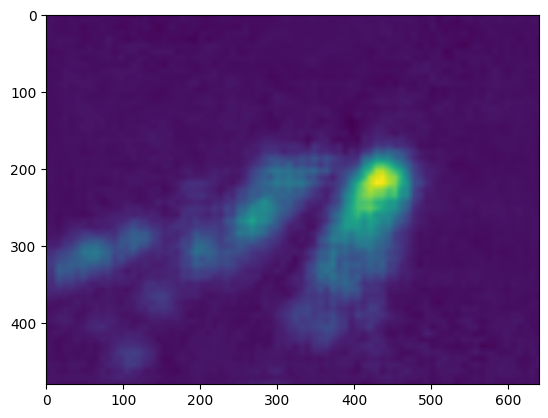

In [66]:
plt.imshow(output/ density_map_scale)

In [67]:
np.sum(output) / density_map_scale, validation_dataset[0][2]

(39.76540832519531, 43.00000000000001)

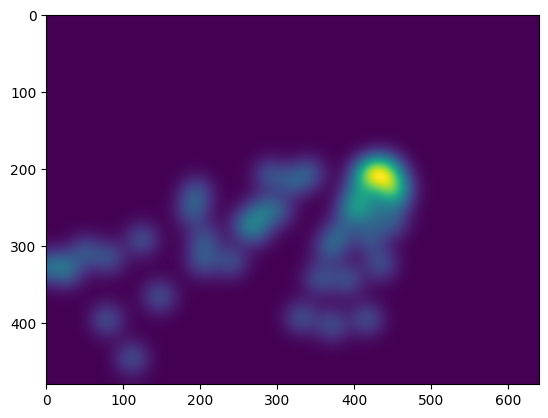

In [68]:
plt.imshow(validation_dataset[0][1].numpy().transpose((1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


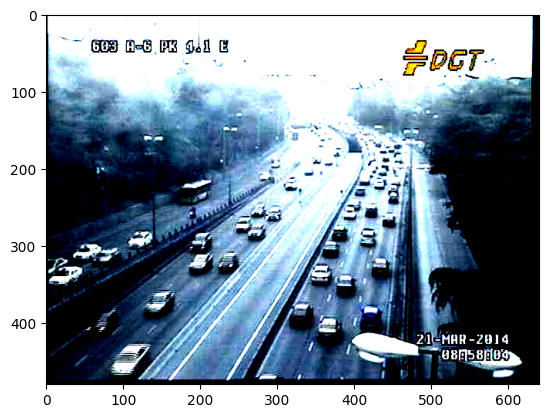

In [69]:
plt.imshow(validation_dataset[0][0].numpy().transpose((1, 2, 0)))